# Feature Importance for Occupancy Rate

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('itpm_airbnb_processed.csv')  # Adjust the path as necessary

# Adjust pandas settings to display all columns
pd.set_option('display.max_columns', None)

df.head()

,Airbnb Host ID,Airbnb Property ID,City_x,superhost_period_all,Superhost,numReviews_pastYear,numCancel_pastYear,prop_5_StarReviews_pastYear,numReserv_pastYear,hostResponseAverage_pastYear,available_days,available_days_aveListedPrice,booked_days,Property Type,Listing Type,Zipcode,Bedrooms,Bathrooms,Neighborhood,Max Guests,Cleaning Fee (USD),Minimum Stay,Number of Photos,Pets Allowed,Instantbook Enabled,Nightly Rate,Number of Reviews,Rating Overall,revenue,occupancy_rate,date_range,Estimated Cases,Estimated Deaths
0,2613,2384,Chicago,17,1,31.0,0.0,1.000000,52.0,100.000000,115.0,58.921739,16.0,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,1,72.0,169.0,100.0,1020.0,0.139130,Jul_19_to_Sep_19,0.0,0.0
1,2613,2384,Chicago,18,1,39.0,0.0,0.974359,56.0,100.000000,162.0,61.500000,30.0,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,1,57.0,178.0,100.0,1338.0,0.185185,Oct_19_to_Dec_19,0.0,0.0
2,2613,2384,Chicago,19,1,39.0,0.0,0.974359,59.0,100.000000,181.0,78.149171,1.0,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,65.0,178.0,100.0,60.0,0.005525,Jan_20_to_Mar_20,5000.0,150.0
3,2613,2384,Chicago,20,1,36.0,0.0,0.972222,54.0,100.000000,187.0,77.352941,46.0,Condominium,Private room,60637,1.0,1.0,Hyde Park,1.0,25.0,2.0,26.0,False,0,65.0,178.0,100.0,3220.0,0.245989,Apr_20_to_Jun_20,70000.0,2150.0
4,5775,4505,Chicago,17,1,23.0,0.0,0.782609,56.0,97.571429,189.0,93.724868,33.0,Apartment,Entire home/apt,60623,3.0,1.0,Little Village,7.0,30.0,2.0,19.0,False,1,108.0,381.0,96.0,3843.0,0.174603,Jul_19_to_Sep_19,0.0,0.0


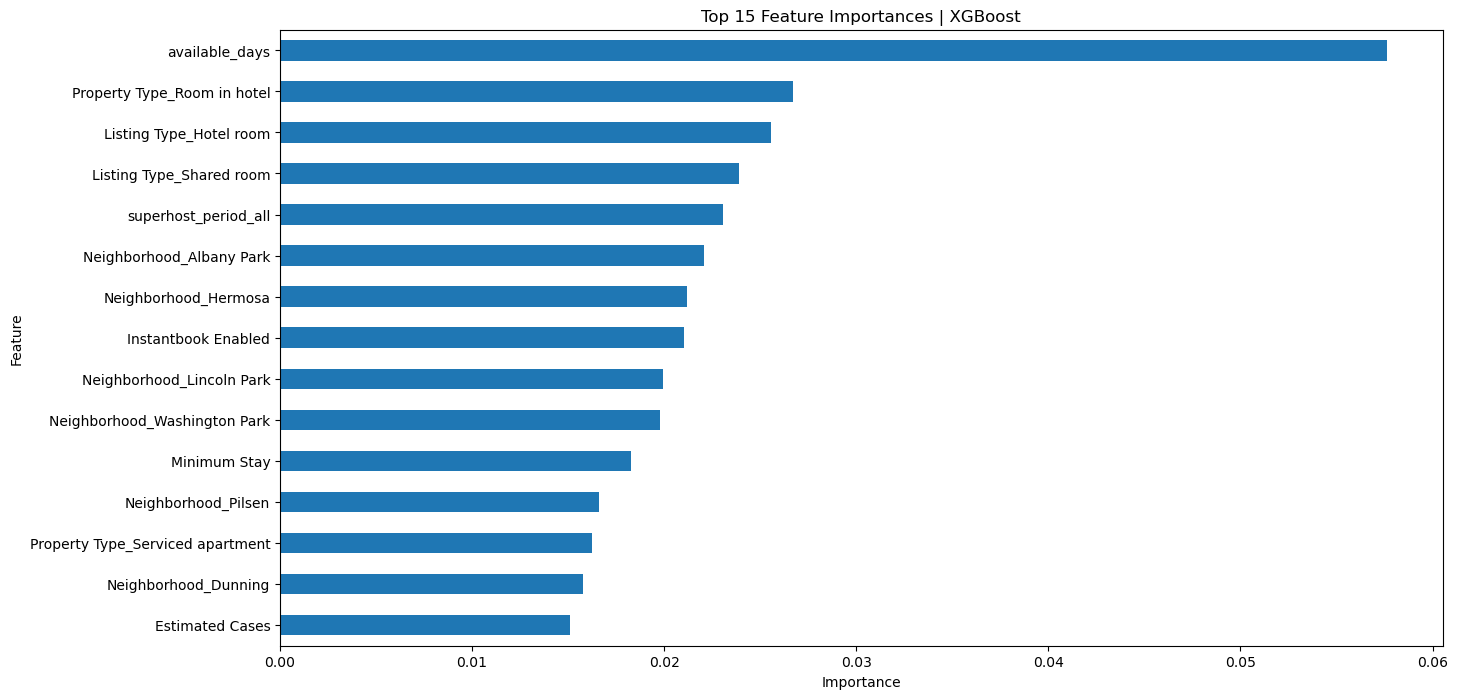

In [3]:
# Prepare the data
X = df.drop(['Airbnb Host ID', 
             'Airbnb Property ID', 
             'City_x', 
             'revenue', 
             'date_range', 
             'revenue', 
             'Zipcode',
             'booked_days',
             'available_days_aveListedPrice',
             'occupancy_rate'
            ], axis=1)
y = df['occupancy_rate']
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Fit the XGBoost model
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Feature importance
feature_importance_xgb = xgb.feature_importances_
columns_transformed = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
columns_remaining = X.select_dtypes(exclude=['object', 'bool']).columns
all_columns = list(columns_transformed) + list(columns_remaining)
feature_importances_xgb_mapped = pd.Series(feature_importance_xgb, index=all_columns).sort_values(ascending=False)

# Plotting feature importance
plt.figure(figsize=(15, 8))
feature_importances_xgb_mapped[:15].plot(kind='barh')
plt.title('Top 15 Feature Importances | XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on the test set
y_pred = xgb.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R² score
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")

Root Mean Squared Error (RMSE): 0.13353793292967742
Mean Absolute Error (MAE): 0.08847003238898739
R² score: 0.42264657389077576


# DiD Analysis

In [4]:
import pandas as pd
import statsmodels.api as sm

# Load the data
df_period = pd.read_csv("itpm_airbnb_period_processed.csv")

In [5]:
df_period

,City_x,superhost_period_all,Airbnb Host ID,Airbnb Property ID,Superhost,available_days,available_days_aveListedPrice,booked_days,Cleaning Fee (USD),Nightly Rate,Number of Reviews,Rating Overall,revenue,occupancy_rate,date_range,Estimated Cases,Estimated Deaths
0,Boston,17,1329,1329,1329,131.836719,206.419447,26.817156,84.928403,209.815337,67.495862,92.137698,5385.373213,0.276074,Jul_19_to_Sep_19,0.0,0.0
1,Boston,18,937,937,937,151.675560,174.555432,17.290288,84.790822,149.796379,76.339381,92.466382,2534.810032,0.145702,Oct_19_to_Dec_19,0.0,0.0
2,Boston,19,723,723,723,156.416321,192.005700,17.614108,89.071845,162.172375,66.000000,92.540802,2672.365145,0.142537,Jan_20_to_Mar_20,2000.0,50.0
3,Boston,20,670,670,670,152.026866,193.589551,18.125373,90.252977,167.958209,65.029851,91.973134,3176.432836,0.154534,Apr_20_to_Jun_20,30000.0,1000.0
4,Chicago,17,5416,5416,5416,162.096750,129.792302,26.842504,71.939264,120.607954,56.195162,95.101366,3727.373523,0.199462,Jul_19_to_Sep_19,0.0,0.0
5,Chicago,18,4824,4824,4824,168.762438,123.564956,17.448176,74.786628,105.467968,60.037106,95.201907,1911.195688,0.125289,Oct_19_to_Dec_19,0.0,0.0
6,Chicago,19,4722,4722,4722,158.260906,133.154999,16.614570,75.919675,106.637243,61.967598,95.389665,2027.633418,0.144578,Jan_20_to_Mar_20,5000.0,150.0
7,Chicago,20,3656,3656,3656,150.333698,147.132051,20.895514,77.671855,114.930525,60.361597,95.175328,2864.279267,0.196221,Apr_20_to_Jun_20,70000.0,2150.0


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'itpm_airbnb_period_processed.csv'
data = pd.read_csv(file_path)

# Preprocess Data: Define COVID-19 Periods
data['COVID_period'] = data['date_range'].apply(lambda x: 'pre' if x in ['Jul_19_to_Sep_19', 'Oct_19_to_Dec_19'] else 'post')

# Group data by city and COVID period and calculate mean of relevant metrics
metrics = ['available_days', 'booked_days', 'revenue', 'occupancy_rate']
grouped_data = data.groupby(['City_x', 'COVID_period'])[metrics].mean().reset_index()

# Function to calculate DID for a given metric
def calculate_did(metric):
    boston_diff = grouped_data.loc[(grouped_data['City_x'] == 'Boston') & (grouped_data['COVID_period'] == 'post'), metric].values[0] - \
                  grouped_data.loc[(grouped_data['City_x'] == 'Boston') & (grouped_data['COVID_period'] == 'pre'), metric].values[0]
    chicago_diff = grouped_data.loc[(grouped_data['City_x'] == 'Chicago') & (grouped_data['COVID_period'] == 'post'), metric].values[0] - \
                   grouped_data.loc[(grouped_data['City_x'] == 'Chicago') & (grouped_data['COVID_period'] == 'pre'), metric].values[0]
    return {'Metric': metric, 'Boston DID': boston_diff, 'Chicago DID': chicago_diff}

# Calculate DID for each metric and store results in a list
did_results = [calculate_did(metric) for metric in metrics]

# Convert the list of results into a DataFrame for tabular display
did_table = pd.DataFrame(did_results)

# Display the results table
did_table

,Metric,Boston DID,Chicago DID
0,available_days,12.465453,-11.132292
1,booked_days,-4.183981,-3.390298
2,revenue,-1035.692632,-373.328263
3,occupancy_rate,-0.062353,0.008024
